# Constant Time-Lag Tides

This adds a constant time lag model (Hut 1981) to tides raised on either the primary and/or the orbiting bodies.

Note that the current implementation does not self-consistently evolve the bodies' spins.
Their respective spin rates params["Omega"] remain fixed in magnitude and are assumed aligned with the $z$ axis of the simulation.

As an example, we'll add the tides raised on a post-main sequence Sun near its tip-RGB phase by the Earth.

In [1]:
import rebound
import reboundx
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

def getsim():
    sim = rebound.Simulation()
    sim.units = ('yr', 'AU', 'Msun') 
    sim.add(m=0.86)        # post-MS Sun
    sim.add(m=3.e-6, a=1., e=0.03) # Earth
    sim.move_to_com()
    rebx = reboundx.Extras(sim)
    tides = rebx.load_force("tides_constant_time_lag")
    rebx.add_force(tides)

    return sim, rebx, tides

We specify the primary and secondaries' equilibrium gravitational response to the tidal field acting on them through the `tctl_k1` apsidal motion constant, equal to half the tidal Love number $k_2$. If we additionally give the primary a physical radius, then any (massive) orbiting body will raise equilibrium tides on the primary. Similarly, if we add a physical radius and `tctl_k1` to any of the orbiting bodies, the primary will raise tides on that particle (but note that orbiting bodies will not raise tides on one another):

In [2]:
sim, rebx, tides = getsim()
ps = sim.particles
ps[0].r = 0.85 # AU
ps[0].params["tctl_k1"] = 0.03

If we stop here and don't add a time lag, we will get the instantaneous equilibrium tide, which provides a conservative, radial non-Keplerian potential. The total energy will be conserved, but the pericenter will precess. 

In [3]:
H0 = sim.calculate_energy() + rebx.tides_constant_time_lag_potential(tides)
tmax = 5000
Nout=1000

pomega, Eerr = np.zeros(Nout), np.zeros(Nout)
times = np.linspace(0,tmax,Nout)

for i, time in enumerate(times):
    sim.integrate(time)
    pomega[i] = ps[1].pomega
    H = sim.calculate_energy() + rebx.tides_constant_time_lag_potential(tides)
    Eerr[i] = abs((H-H0)/H0)

Text(0, 0.5, 'Energy Error')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


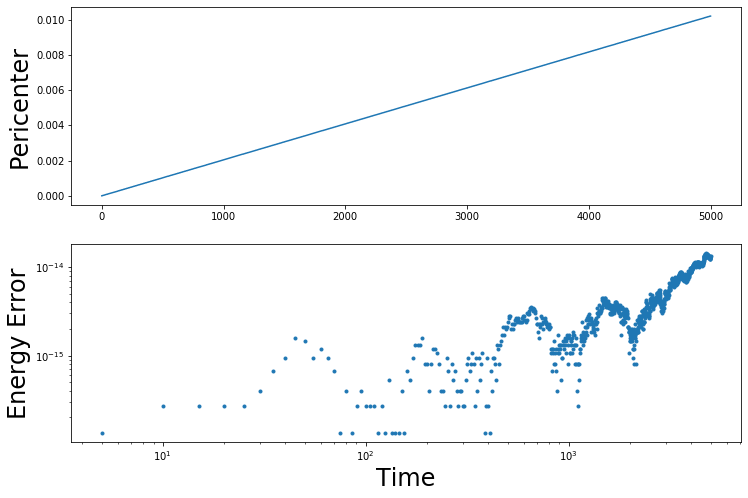

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, axarr = plt.subplots(nrows=2, figsize=(12,8))
axarr[0].plot(times, pomega)
axarr[0].set_ylabel("Pericenter", fontsize=24)
axarr[1].plot(times, Eerr, '.')
axarr[1].set_xscale('log')
axarr[1].set_yscale('log')
axarr[1].set_xlabel('Time', fontsize=24)
axarr[1].set_ylabel('Energy Error', fontsize=24)

If we additionally set the `tctl_tau` constant time lag parameter, this delayed response introduces dissipation, which will typically cause eccentricity damping, and will migrate the orbiting bodies either inward or outward depending on whether they orbit faster or slower than the spin of the tidally deformed body. We set the spin rate of each body with the `Omega` parameter. If it is not set, `Omega` is assumed to be zero.

As noted above, this implementation assumes bodies' spins are fixed and don't evolve self-consistently, so consider whether more angular momentum is being exchanged in the system than is available in the spins! We additionally assume that bodies spins are aligned with the reference z axis. 

As an example:

In [5]:
sim, rebx, tides = getsim()
ps = sim.particles
ps[0].r = 0.85 # AU
ps[0].params["tctl_k1"] = 0.03
ps[0].params["Omega"] = 0 # explicitly set to 0 (would be 0 by default)
ps[0].params["tctl_tau"] = 0.4 # SET ON THE PLANET

We can compare to the theoretical prediction assuming a circular orbit (see Hut 1981). We'll integrate for 25,000 years and store the Earth's semi-major axis and eccentricity.

In [6]:
import numpy as np
tmax = 2.5e4
Nout=1000

a, e = np.zeros(Nout), np.zeros(Nout)
times = np.linspace(0,tmax,Nout)
# to plot physical radius of the Sun
R0 = 0*times + ps[0].r

q = (ps[1].m/ps[0].m)
T = ps[0].r**3/sim.G/ps[0].m/ps[0].params["tctl_tau"]
apred = ps[0].r*((ps[1].a/ps[0].r)**8 - 48.*ps[0].params["tctl_k1"]*q*(1+q)*times/T)**(1./8.)

In [7]:
%%time
for i, time in enumerate(times):
    sim.integrate(time)
    a[i] = ps[1].a
    e[i] = ps[1].e

CPU times: user 8.77 s, sys: 10.5 ms, total: 8.78 s
Wall time: 8.79 s


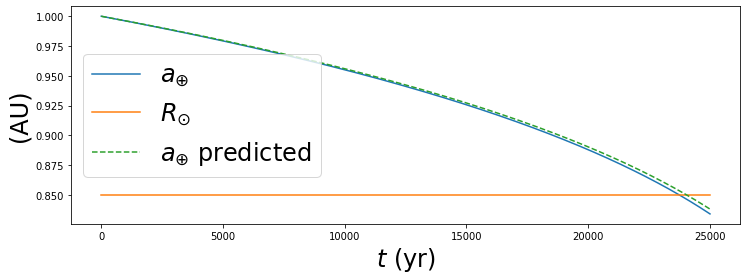

In [8]:
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(times, a, label='$a_{\oplus}$')
ax.plot(times, R0, label='$R_{\odot}$')
ax.plot(times, apred, '--', label='$a_{\oplus}$ predicted')
ax.set_xlabel('$t$ (yr)', fontsize=24)
ax.set_ylabel('(AU)', fontsize=24)
ax.legend(fontsize=24, loc='best')

We can also check that the eccentricity decays:

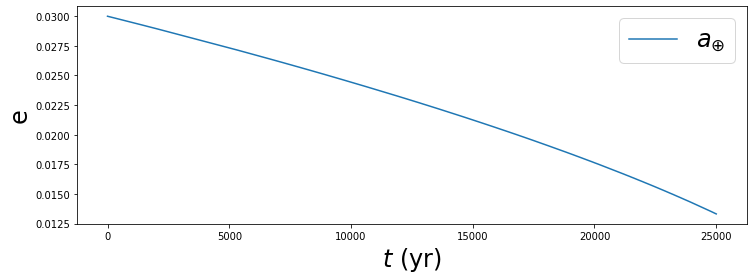

In [9]:
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(times, e, label='$a_{\oplus}$')
ax.set_xlabel('$t$ (yr)', fontsize=24)
ax.set_ylabel('e', fontsize=24)
ax.legend(fontsize=24, loc='best')

While the above examples only considered tides raised on the star, you can also model the tides raised on the planets by setting their corresponding paremeters, e.g.

In [37]:
ps[1].params['tctl_k1'] = 0.3
ps[1].params['tctl_tau'] = 0.8
ps[1].r = 5e-5 # AU

# Having independent tidal dissipation parameters in the star for the tides raised by different planets

In some tidal models, planets can raise enhanced tides at particular orbital frequencies, leading to enhanced dissipation at resonances with particular modes in the primary. This implies that different planets could generate very different tidal time lags in the host star.

By default, setting `particles[0].params['tctl_tau']` sets the same tidal time lag in the star for all planets. If we want one or more planets to generate different stellar time lags, we can set them individually

In [ ]:
sim, rebx, tides = getsim()
sim.add(m=3.e-6, a=1.3, e=0.03) # Earth)

ps = sim.particles
ps[0].r = 0.85 # AU
ps[0].params["tctl_k1"] = 0.03
ps[0].params["Omega"] = 0 # explicitly set to 0 (would be 0 by default)

As an artificial example, let's make the outer planet (which would otherwise feel weaker tide) generate much stronger dissipation in the star:

In [33]:
ps[1].params["tctl_primary_tau"] = 0.01 # time lag for the STAR, generated by the planet
ps[2].params["tctl_primary_tau"] = 1    # time lag for the STAR, generated by the planet

In [34]:
tmax = 1e4
Nout=1000

e1, e2 = np.zeros(Nout), np.zeros(Nout)
times = np.linspace(0,tmax,Nout)

for i, time in enumerate(times):
    sim.integrate(time)
    e1[i] = ps[1].e
    e2[i] = ps[2].e

We can see that as a result, the eccentricity of the outer planet damps faster due to the enhanced dissipation:

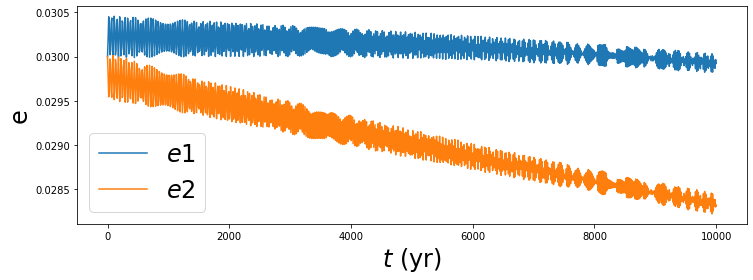

In [35]:
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(times, e1, label='$e1$')
ax.plot(times, e2, label='$e2$')
ax.set_xlabel('$t$ (yr)', fontsize=24)
ax.set_ylabel('e', fontsize=24)
ax.legend(fontsize=24, loc='best')